In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [4]:
def build_unet_for_classification(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Global Average Pooling for Classification
    gap = GlobalAveragePooling2D()(c9)
    outputs = Dense(num_classes, activation='softmax')(gap)

    model = Model(inputs, outputs)
    return model


In [5]:
def load_data(image_size):
    X = []
    Y = []
    labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

    for label in labels:
        folder_path = os.path.join(r"C:\\Users\\Jayaraj.V\\Downloads\\tumer\\Training", label)
        for img_name in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, img_name))
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))

    X = np.array(X) / 255.0  # Normalize images
    Y = to_categorical(np.array(Y), num_classes=len(labels))  # One-hot encode labels
    return X, Y


In [7]:
# Build and compile the U-Net model for classification
model = build_unet_for_classification((image_size, image_size, 3), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 128, 128, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 128, 128, 64)      │          36,928 │ conv2d_19[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 64, 64, 64)        │               0 │ conv2d_20[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 64, 64, 128)       │         147,584 │ conv2d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 32, 32, 128)       │               0 │ conv2d_22[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 32, 32, 256)       │         590,080 │ conv2d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 16, 16, 256)       │               0 │ conv2d_24[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 16, 16, 512)       │       1,180,160 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 8, 8, 512)         │               0 │ conv2d_26[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 8, 8, 1024)        │       4,719,616 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 8, 8, 1024)        │       9,438,208 │ conv2d_27[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,031,940 (118.38 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Set parameters
image_size = 128
num_classes = 4
batch_size = 16
epochs = 20

# Load dataset
X, Y = load_data(image_size)
X, Y = shuffle(X, Y, random_state=101)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=101)


In [9]:
# Build and compile the U-Net model for classification
model = build_unet_for_classification((image_size, image_size, 3), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_37 (Conv2D)            │ (None, 128, 128, 64)      │           1,792 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_38 (Conv2D)            │ (None, 128, 128, 64)      │          36,928 │ conv2d_37[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 64, 64, 64)        │               0 │ conv2d_38[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_39 (Conv2D)            │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_40 (Conv2D)            │ (None, 64, 64, 128)       │         147,584 │ conv2d_39[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 32, 32, 128)       │               0 │ conv2d_40[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_42 (Conv2D)            │ (None, 32, 32, 256)       │         590,080 │ conv2d_41[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_10              │ (None, 16, 16, 256)       │               0 │ conv2d_42[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_43 (Conv2D)            │ (None, 16, 16, 512)       │       1,180,160 │ max_pooling2d_10[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_44 (Conv2D)            │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_43[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_11              │ (None, 8, 8, 512)         │               0 │ conv2d_44[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_45 (Conv2D)            │ (None, 8, 8, 1024)        │       4,719,616 │ max_pooling2d_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_46 (Conv2D)            │ (None, 8, 8, 1024)        │       9,438,208 │ conv2d_45[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,031,940 (118.38 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=batch_size, epochs=epochs)


Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 1183s 7s/step - accuracy: 0.3631 - loss: 1.3519 - val_accuracy: 0.4530 - val_loss: 1.1894
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.5013 - loss: 1.1297 - val_accuracy: 0.4390 - val_loss: 1.3133
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 660s 4s/step - accuracy: 0.4293 - loss: 35.3130 - val_accuracy: 0.4077 - val_loss: 1.3148
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 648s 4s/step - accuracy: 0.4118 - loss: 1.2659 - val_accuracy: 0.5679 - val_loss: 1.1617
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.4982 - loss: 1.1731 - val_accuracy: 0.5575 - val_loss: 1.1094
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 631s 4s/step - accuracy: 0.5209 - loss: 1.0729 - val_accuracy: 0.5784 - val_loss: 1.0339
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.5541 - loss: 1.0481 - val_accuracy: 0.5819 - val_loss: 1.0850
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.5551 - loss: 1.0408 - val_ac

In [11]:
model.save(r'C:\lite\brain_tumor_unet_classification(4).h5')


In [12]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


In [13]:
# Load the trained model
model = load_model(r'C:\lite\brain_tumor_unet_classification(4).h5')

# Define class labels (should match the labels used during training)
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [14]:
def preprocess_image(image_path, image_size):
    """
    Preprocess the input image to match the model's input size.
    Args:
        image_path: Path to the input image.
        image_size: Target size (width and height) for resizing.
    Returns:
        Preprocessed image ready for prediction.
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))  # Resize the image
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [15]:
def predict_image(model, image_path, image_size, class_labels):
    """
    Predict whether an image contains a tumor or not using the trained model.
    Args:
        model: Trained Keras model.
        image_path: Path to the input image.
        image_size: Size the model expects for input images.
        class_labels: List of class labels used during training.
    Returns:
        Predicted class and confidence score.
    """
    # Preprocess the image
    preprocessed_img = preprocess_image(image_path, image_size)

    # Make a prediction
    prediction = model.predict(preprocessed_img)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]

    return predicted_class, confidence


In [21]:
# Path to the test image (replace this with your image file path)
image_path = r"C:\Users\Jayaraj.V\Downloads\tumer\Training\pituitary_tumor\p (683).jpg"

# Define the image size (same as used during training)
image_size = 128

# Predict the class
predicted_class, confidence = predict_image(model, image_path, image_size, class_labels)

# Output the result
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Class: glioma_tumor
Confidence: 0.42


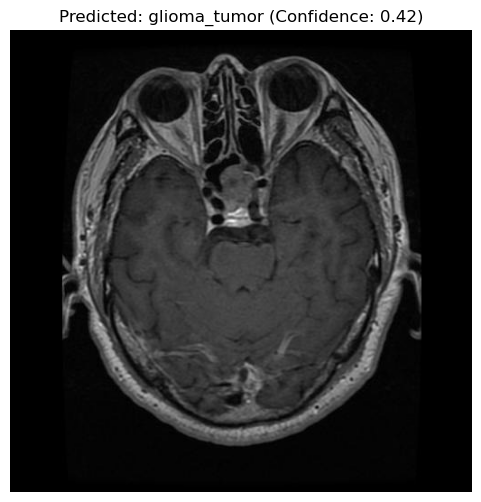

In [22]:
# Read the image for visualization
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)

# Plot the image and prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()
